In [ ]:
import jax.numpy as np
from scipy.special import j1
import jax.random as jr
import matplotlib.pyplot as plt
import dLux as dl
import dLuxToliman as dlT
import dLux.utils as dlu

In [1326]:
min_wavelength = 560e-9
max_wavelength = 1500e-9#610e-9
delta_wavelength = max_wavelength - min_wavelength
n_wavelengths = 2*1024

period = 300e-6
diameter = 0.125

wavelengths = np.linspace(min_wavelength, max_wavelength, n_wavelengths*2)

# percentage over in xvals: 10% of wavlength range
x_buffer = 0.1

min_x = (np.sqrt(2)/period) * (min_wavelength - x_buffer * delta_wavelength)
max_x = (np.sqrt(2)/period) * (max_wavelength + x_buffer * delta_wavelength)

# adding lots of x values to sample
n_x = int(np.ceil((1+2*x_buffer)*n_wavelengths))

x = np.linspace(min_x, max_x, n_x)

In [1330]:
# code for generating an arbitrary flux spectrum:
key = jr.PRNGKey(5)

# Create a complex array of zeros
spectrum = np.zeros(n_wavelengths, dtype=np.complex64)

d_wl = wavelengths[1]-wavelengths[0]
fs = 1 / d_wl           # sampling frequency
freqs = np.fft.fftfreq(n_wavelengths, d=d_wl)

# Desired frequency band (in Hz)
f_low = 0

max_spec_freq = (np.sqrt(2)/period) * (diameter/min_wavelength)

f_high = 2 * max_spec_freq
# Get indices of freqs within band (positive freqs only)
band_mask = (freqs >= f_low) & (freqs <= f_high)

# Random amplitudes and phases
amp_key, phase_key = jr.split(key)
random_amplitudes = jr.normal(amp_key, shape=(n_wavelengths,)) * band_mask
random_phases = jr.uniform(phase_key, shape=(n_wavelengths,), minval=0.0, maxval=2 * np.pi)

# Assign complex values
spectrum = random_amplitudes * np.exp(1j * random_phases)

# Make symmetric to ensure real time-domain signal
# Copy positive freqs into negative side
def make_hermitian(spec):
    spec = spec.at[1:n_wavelengths//2].set(spec[1:n_wavelengths//2])
    spec = spec.at[-(n_wavelengths//2)+1:].set(np.conj(spec[1:n_wavelengths//2][::-1]))
    return spec

spectrum = make_hermitian(spectrum)

signal = np.fft.ifft(spectrum).real
spectrum_filtered_bad = spectrum.at[np.abs(freqs) > max_spec_freq].set(0)
signal_filtered_bad = np.fft.ifft(spectrum_filtered_bad).real

#plt.plot(signal)

if np.min(signal) <= 0:
    signal_filtered_bad += -2*np.min(signal)
    signal += -2*np.min(signal)

signal = np.append(np.append(np.zeros(1024),signal),np.zeros(1024)) + 0.01

In [1331]:
# what about for just random noise
signal_2 = jr.uniform(key, (n_wavelengths,))+1

freqs = np.fft.fftfreq(int(2*n_wavelengths), d=d_wl)
signal_fft = np.fft.fft(signal)
max_freq = 1*max_spec_freq
signal_fft_filtered = signal_fft.at[np.abs(freqs)> max_freq].set(0)
signal_filtered = np.fft.ifft(signal_fft_filtered).real

In [1534]:
def strange_mellin(wavelengths, weights, freqs):
    d_wl = wavelengths[1]-wavelengths[0]
    mellin = np.zeros_like(freqs, dtype=np.complex64)
    for idx, freq in enumerate(freqs):
        mel = np.sum(weights * wavelengths**(-1j * freq - 2) * d_wl)
        mellin = mellin.at[idx].set(mel)
    return mellin

def h_kernel(tau, alpha, diam):
    arg = np.pi*diam*(tau-alpha)
    num = j1(arg)**2
    denom = arg**2
    h_ker = np.where(arg==0, (np.pi*diam**2), (np.pi * diam**2)*num/denom)
    return h_ker

def mellin_h(h, tau, freqs):
    d_tau = tau[1]-tau[0]
    mell_h = np.zeros_like(freqs, dtype=np.complex64)
    for idx, freq in enumerate(freqs):
        mel_h = np.sum(h * tau**(-1j * freq - 1) * d_tau)
        mell_h = mell_h.at[idx].set(mel_h)
    return mell_h

In [1625]:
# analytic version for alpha = 0:
from scipy.special import gamma
from scipy.special import poch
from scipy.special import factorial
def h_analytic(freqs, diam):
    num = gamma(1 + (1j*freqs)/2) * gamma(1/2 - (1j*freqs)/2)
    denom = 2 * np.sqrt(np.pi) * gamma(3/2 + (1j * freqs)/2) * gamma(5/2 + (1j * freqs)/2)
    prefac = np.pi**(1j * freqs) * diam**(1j * freqs + 1)
    h_an = prefac * num/denom
    return h_an

# numerical version for any alpha
def h_num(freqs, tau, alph, diam):
    a = np.pi * diam * alph
    v = np.pi * diam * tau
    d_v = v[1]-v[0]
    hnum = np.zeros_like(freqs, dtype=np.complex64)
    for idx, freq in enumerate(freqs):
        hnum = hnum.at[idx].set(np.sum(np.where(v - a <=0, 0, j1(v-a)**2/(v-a) * v**(-1j*freq-1) * d_v)))
        
    hnum *= (np.pi**(1j*freqs)*diam**(1j*freqs+1))/(1-alph)
    return hnum

def mel_j1(s):
    num = gamma(1/2 - s/2) * gamma(s/2 + 1)
    denom = 2*np.sqrt(np.pi) * gamma(1 - s/2) * gamma(2 - s/2)
    mj = num/denom
    return mj

def mel_j1num(s, t):
    d_t = t[1] - t[0]
    mj1num = np.sum(j1(t)**2 * t**(s-1) * d_t)
    return mj1num

def pochammer(arg, k):
    poc = gamma(arg+k)/gamma(arg)
    return poc

def h_positive(freqs, alph, diam):
    a = np.pi * diam * alph

    h_plus = a**(-1j*freqs - 1)
    summa = np.zeros_like(freqs, dtype=np.complex64)

    for k in range(1):
        mj = mel_j1(k)
        prefac = pochammer(-1j * freqs - 1, k)/(factorial(k)*(a**k))
        summa += prefac*mj

    h_plus *= summa
    return h_plus


# might be worth defining a different conjugate frequency domain but this is ok so far..
fmel_max = 4000#2000#3700# 365#397
n_freqs = 1024#*8
# 2048 seems like enough
freqs_shifted = np.linspace(-fmel_max, fmel_max, n_freqs)
#freqs_shifted = np.fft.fftshift(np.fft.fftfreq(16384, d=(1/dfreq)))
melweights = strange_mellin(wavelengths, signal, freqs_shifted)

# other stuff
alpha = 1*np.sqrt(2)/period
tau = np.linspace(np.max(np.array([0.01,alpha-100])), alpha+100, 1024)
hker = h_kernel(tau, alpha, diameter)

mel_h = mellin_h(hker, tau, freqs_shifted)

hnum = h_num(freqs_shifted, tau, alpha, diameter)

h_an = h_analytic(freqs_shifted, diameter)
h_an = np.nan_to_num(h_an, 0)

h_plus = h_positive(freqs_shifted, alpha, diameter)
h_plus = np.nan_to_num(h_plus, 0)

/var/folders/2s/299fsjvd5w13x4x_w7x554fh0000gn/T/ipykernel_1322/1107768793.py:36: RuntimeWarning: overflow encountered in divide
  poc = gamma(arg+k)/gamma(arg)
/var/folders/2s/299fsjvd5w13x4x_w7x554fh0000gn/T/ipykernel_1322/1107768793.py:36: RuntimeWarning: invalid value encountered in divide
  poc = gamma(arg+k)/gamma(arg)


In [1626]:
t = np.linspace(0.01,1000000000,10*1024)
print(mel_j1num(2, t))
print(mel_j1(-1.4))

318509400.0
0.5520586


In [1627]:
print(h_plus[512])

(-0.00011187296+0.0002458367j)


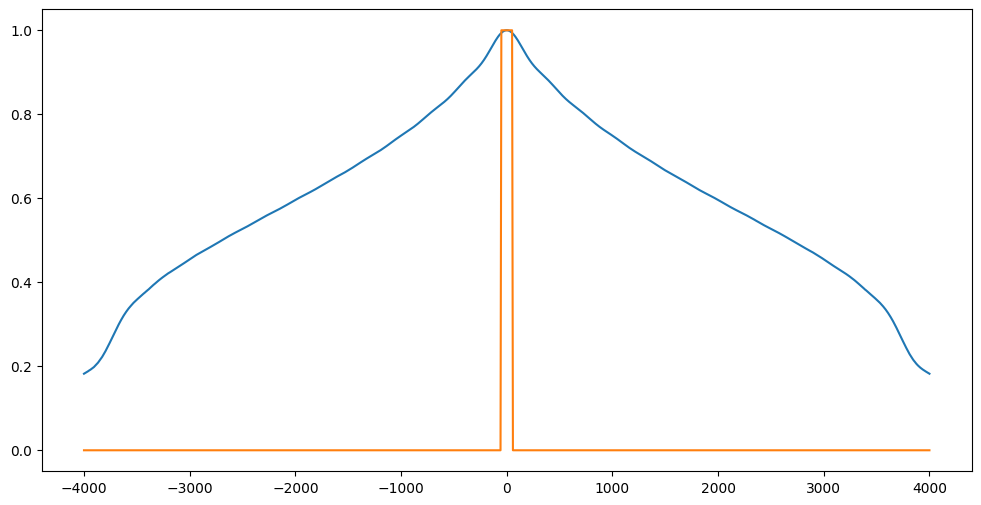

In [1628]:
plt.figure(figsize=(12,6))
#plt.plot(freqs_shifted,np.abs(mel_h))
#plt.plot(freqs_shifted, 0.0000225*np.exp(-1/(1-(freqs_shifted/3600)**2)))
#plt.plot(freqs_shifted, np.abs(h_an))#/np.max(np.abs(h_an)))
plt.plot(freqs_shifted, np.abs(hnum)/np.max(np.abs(hnum)))
plt.plot(freqs_shifted, np.abs(h_plus)/np.max(np.abs(h_plus)))
#plt.ylim(0,0.000025)
#plt.xlim(-4000,4000)
#plt.plot(tau,hker)
plt.show()

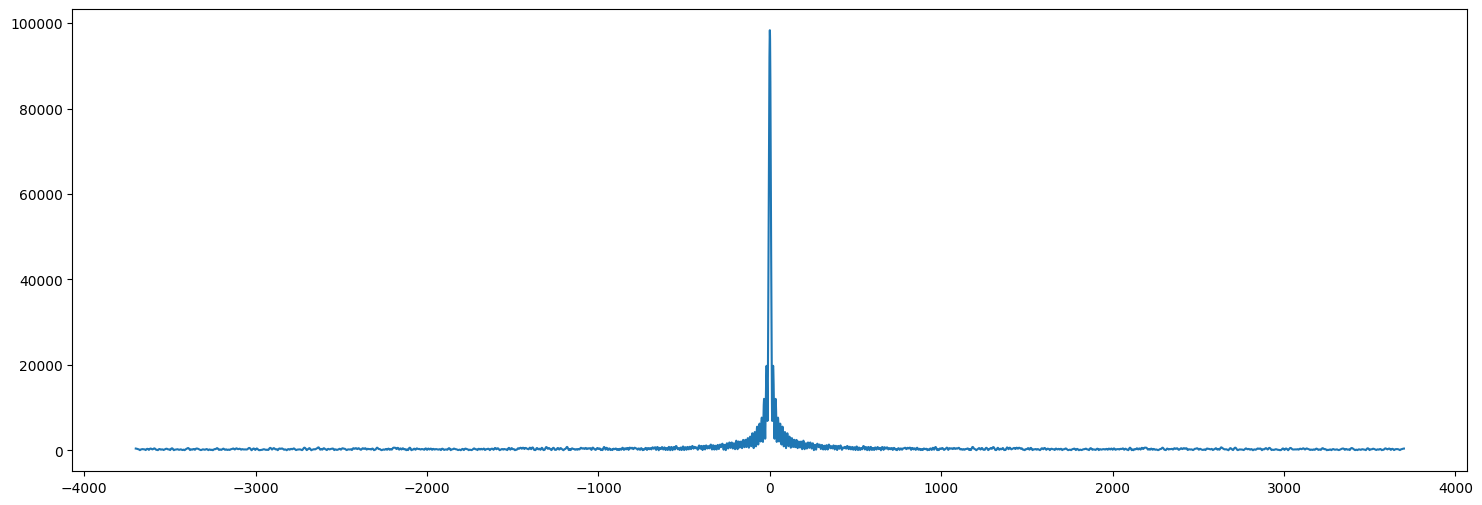

In [1370]:
plt.figure(figsize=(18,6))
plt.plot(freqs_shifted, np.abs(melweights))
#plt.xlim(-1000,1000)
plt.show()

In [1336]:
def inverse_mellin(wavelengths, melweights, freqs):
    d_freq = freqs[1] - freqs[0]
    inv_mellin = np.zeros_like(wavelengths, dtype=np.complex64)
    for idx, wl in enumerate(wavelengths):
        inv_mel = np.sum(melweights * wl**(1j * freqs) * d_freq)
        inv_mellin = inv_mellin.at[idx].set(inv_mel)
    inv_mellin *= wavelengths/(2*np.pi)
    return inv_mellin

In [1337]:
inv_melweights = inverse_mellin(wavelengths, melweights, freqs_shifted).real

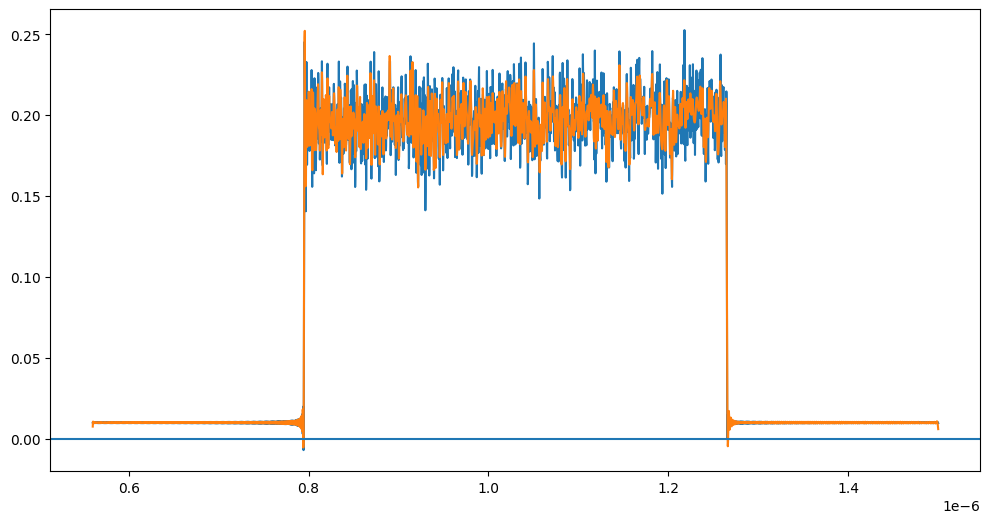

In [1338]:
plt.figure(figsize=(12,6))
plt.plot(wavelengths, signal_filtered)
plt.plot(wavelengths, inv_melweights)#(inv_melweights.real-np.median(inv_melweights.real))*1000000*wavelengths**1 + np.median(inv_melweights.real))
#plt.plot(wavelengths, signal, linestyle = '--')#/np.median(signal))
plt.axhline(0)
#plt.xlim(565e-9,600e-9)
plt.show()

In [1263]:
print(np.sum(inv_melweights)/np.sum(signal))

0.999919


In [1264]:
flux = 40*(2.909*10**7)*(4/11)

difference = np.pi * 0.348
flux_renorm = flux #/(jv(0, difference/4)**2 * jv(1, difference/4)**2)

source = dl.PointSource(wavelengths, flux=flux_renorm, weights=signal)

source_melfiltered = dl.PointSource(wavelengths, flux=flux_renorm*np.sum(inv_melweights)/np.sum(signal), weights=inv_melweights)

source_filtered = dl.PointSource(wavelengths, flux=flux_renorm, weights = signal_filtered)

wf_npixels = 128 # 128 lowest power of 2 necessary

apertureLayer = dlT.TolimanApertureLayer(wf_npixels)

layers = [
    (
        'aperture',
        apertureLayer
    )
]

psf_npixels = 128
assumed_pixel_scale = 0.375

psf_pixel_scale = assumed_pixel_scale

oversample = 2 # 4 seems good

optics = dl.AngularOpticalSystem(wf_npixels,diameter,layers,psf_npixels,psf_pixel_scale,oversample)
center_wl = np.mean(wavelengths)#585e-9

telescope = dl.Telescope(optics, source)
telescope_melfiltered = dl.Telescope(optics, source_melfiltered)
telescope_filtered = dl.Telescope(optics, source_filtered)

sidelobescope = dlT.SideLobeTelescope(telescope, period, difference)
sidelobescope_melfiltered = dlT.SideLobeTelescope(telescope_melfiltered, period, difference)
sidelobescope_filtered = dlT.SideLobeTelescope(telescope_filtered, period, difference)

# model sure to include our assumed pixel scale
sidelobe_raw = sidelobescope.model_sidelobes(center_wavelength = center_wl, assumed_pixel_scale = assumed_pixel_scale, downsample = oversample)
sidelobe_melfiltered_raw = sidelobescope_melfiltered.model_sidelobes(center_wavelength = center_wl, assumed_pixel_scale = assumed_pixel_scale, downsample=oversample)
sidelobe_filtered_raw = sidelobescope_filtered.model_sidelobes(center_wavelength = center_wl, assumed_pixel_scale = assumed_pixel_scale, downsample=oversample)

Model time: 33.9360 seconds.
Model time: 33.9039 seconds.
Model time: 35.6260 seconds.


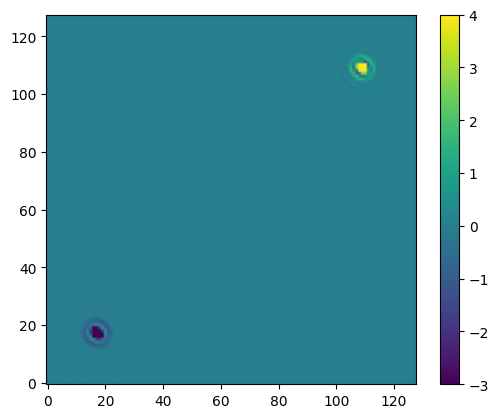

In [1265]:
plt.imshow(sidelobe_filtered_raw - sidelobe_raw, origin='lower', vmin=-3,vmax=4)
# plt.xlim(40,80)
# plt.ylim(40,80)
plt.colorbar()
plt.show()

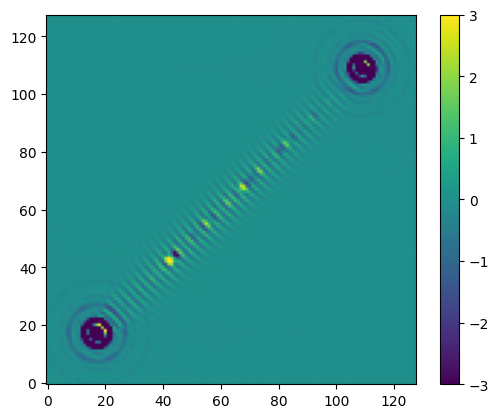

In [1268]:
plt.imshow((sidelobe_melfiltered_raw*0.99944 - sidelobe_raw), origin='lower',vmin=-3,vmax=3)
# plt.xlim(40,80)
# plt.ylim(40,80)
plt.colorbar()
plt.show()

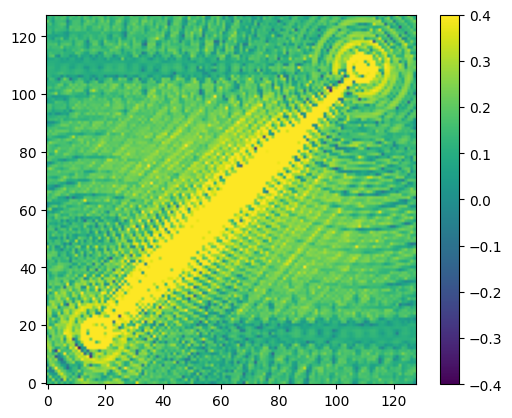

In [1269]:
plt.imshow(np.abs(sidelobe_melfiltered_raw - sidelobe_raw)**0.2 - np.abs(sidelobe_filtered_raw - sidelobe_raw)**0.2, origin='lower',vmin=-0.4,vmax=0.4)
plt.colorbar()
plt.show()

In [1270]:
print(np.sum(np.abs(sidelobe_melfiltered_raw - sidelobe_raw)**2))
print(np.sum(np.abs(sidelobe_filtered_raw - sidelobe_raw)**2))

539631.4
4648.5737


In [1271]:
print(np.sum(sidelobe_melfiltered_raw))
print(np.sum(sidelobe_raw))

7383926.5
7384449.0


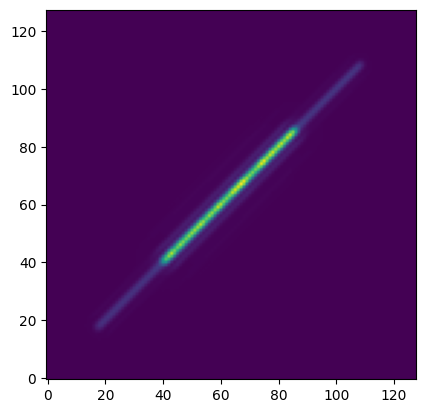

In [1272]:
plt.imshow(sidelobe_raw,origin='lower')
plt.show()

In [ ]:
# I'm really not certain why this doesn't work... it in theory should definitely give a much better basis than just the fourier basis
# perhaps try larger wavelenght range idk